In [ ]:
import os
os.getcwd()

In [120]:
import numpy as np
import re
from easydict import EasyDict as edict
import math
import cv2
import matplotlib.pyplot as plt

In [121]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [122]:
root = os.path.join('RTM','data','kitti')
train_folder = os.path.join(root,'training')

In [123]:
ann_folder = os.path.join(train_folder, 'label_2', '')
cal_folder = os.path.join(train_folder, 'calib', '')
im_folder = os.path.join(train_folder, 'image_2', '')

In [124]:
idx = 8

In [125]:
img_path =  os.path.join(im_folder, "%06d.png" % (idx))
label_path = os.path.join(ann_folder, "%06d.txt" % (idx))
calpath = os.path.join(cal_folder,"%06d.txt" % (idx))

In [126]:
pred_path = '/home/kaixin1/Project/RTM/exp/ddd/3dop/results/'+"%06d.txt" % (idx)

In [138]:
p2 = read_kitti_cal(calpath)
p2_inv = np.linalg.inv(p2)
gts = read_kitti_label(label_path, p2, True)
predits = read_kitti_label(pred_path, p2, True)

<Figure size 1440x1440 with 0 Axes>

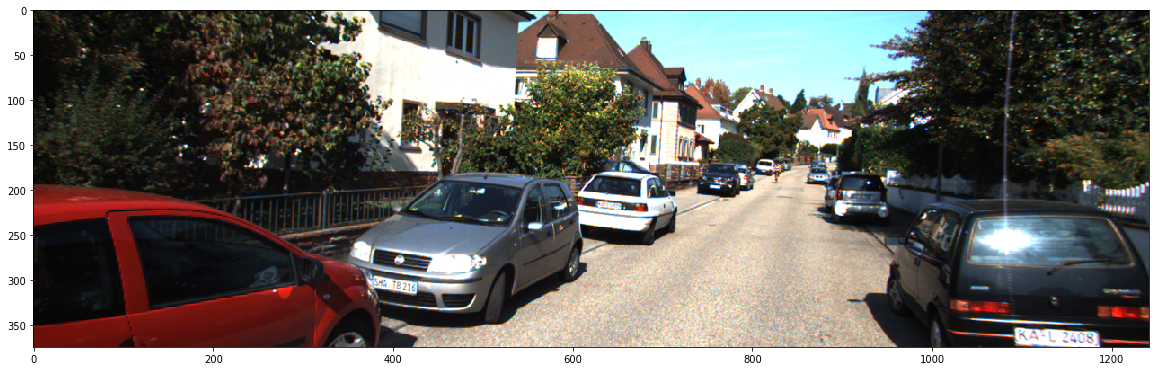

In [136]:
im = cv2.imread(img_path)
plt.figure(figsize=(20,20))
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [133]:
def visualize(im,gts):
    img = im.copy()
    for gt in gts:
        if 'verts3d' in gt.keys():
            verts = gt['verts3d']
            draw_3d_box(img, verts)
    plt.figure(figsize=(20,20))
    
    plt.imshow(img)

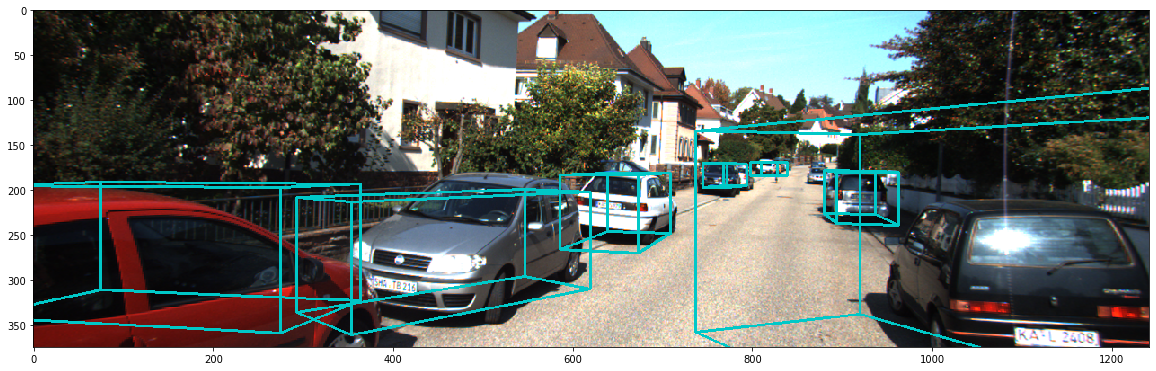

In [139]:
visualize(im,predits)

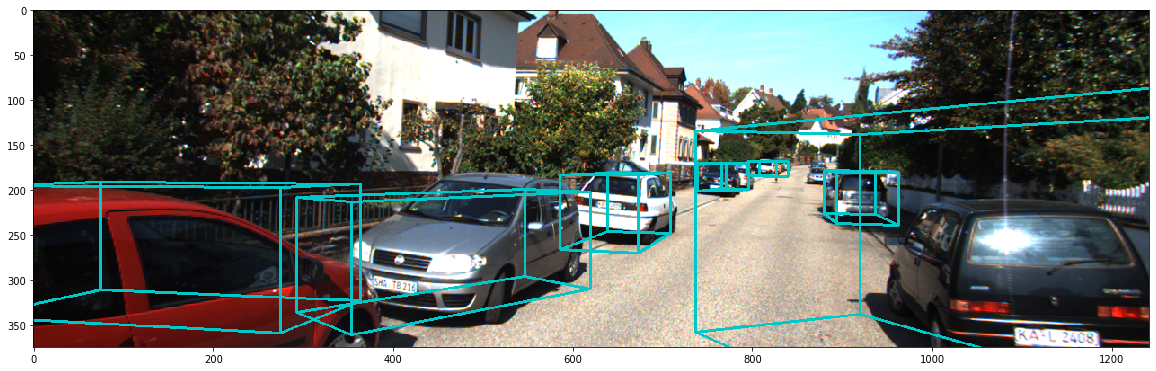

In [137]:
visualize(im,predits)

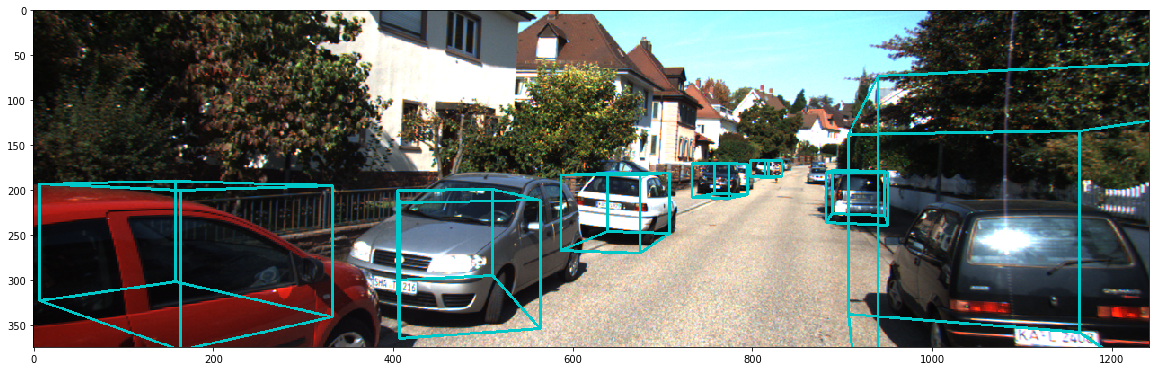

In [88]:
visualize(im,predits)

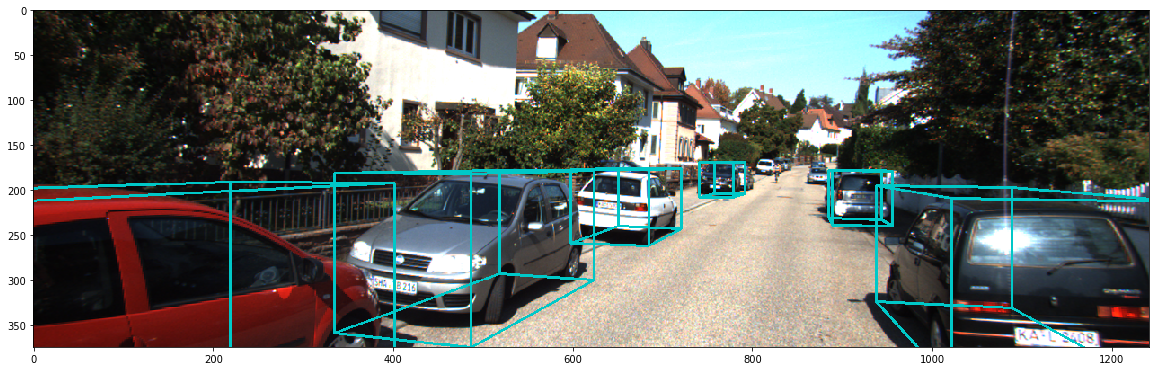

In [84]:
visualize(im,gts)

In [57]:
def draw_3d_box(im, verts, color=(0, 200, 200), thickness=2):
    for lind in range(0, verts.shape[0] - 1):
        v1 = verts[lind]
        v2 = verts[lind + 1]
        cv2.line(im, (int(v1[0]), int(v1[1])), (int(v2[0]), int(v2[1])), color, thickness)

In [5]:

def project_3d(p2, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, return_3d=False):
    """
    Projects a 3D box into 2D vertices

    Args:
        p2 (nparray): projection matrix of size 4x3
        x3d: x-coordinate of center of object
        y3d: y-coordinate of center of object
        z3d: z-cordinate of center of object
        w3d: width of object
        h3d: height of object
        l3d: length of object
        ry3d: rotation w.r.t y-axis
    """

    # compute rotational matrix around yaw axis
    R = np.array([[+math.cos(ry3d), 0, +math.sin(ry3d)],
                  [0, 1, 0],
                  [-math.sin(ry3d), 0, +math.cos(ry3d)]])

    # 3D bounding box corners
    x_corners = np.array([0, l3d, l3d, l3d, l3d,   0,   0,   0])
    y_corners = np.array([0, 0,   h3d, h3d,   0,   0, h3d, h3d])
    z_corners = np.array([0, 0,     0, w3d, w3d, w3d, w3d,   0])

    x_corners += -l3d / 2
    y_corners += -h3d / 2
    z_corners += -w3d / 2

    # bounding box in object co-ordinate
    corners_3d = np.array([x_corners, y_corners, z_corners])

    # rotate
    corners_3d = R.dot(corners_3d)

    # translate
    corners_3d += np.array([x3d, y3d, z3d]).reshape((3, 1))

    corners_3D_1 = np.vstack((corners_3d, np.ones((corners_3d.shape[-1]))))
    corners_2D = p2.dot(corners_3D_1)
    corners_2D = corners_2D / corners_2D[2]

    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]

    verts3d = (corners_2D[:, bb3d_lines_verts_idx][:2]).astype(float).T

    if return_3d:
        return verts3d, corners_3d
    else:
        return verts3d

In [6]:
def convertRot2Alpha(ry3d, z3d, x3d):

    alpha = ry3d - math.atan2(-z3d, x3d) - 0.5 * math.pi
    #alpha = ry3d - math.atan2(x3d, z3d)# - 0.5 * math.pi

    while alpha > math.pi: alpha -= math.pi * 2
    while alpha < (-math.pi): alpha += math.pi * 2

    return alpha


In [24]:
def read_kitti_label(file, p2, use_3d_for_2d=False):
    """
    Reads the kitti label file from disc.

    Args:
        file (str): path to single label file for an image
        p2 (ndarray): projection matrix for the given image
    """

    gts = []

    text_file = open(file, 'r')

    '''
     Values    Name      Description
    ----------------------------------------------------------------------------
       1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                         'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                         'Misc' or 'DontCare'
       1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                         truncated refers to the object leaving image boundaries
       1    occluded     Integer (0,1,2,3) indicating occlusion state:
                         0 = fully visible, 1 = partly occluded
                         2 = largely occluded, 3 = unknown
       1    alpha        Observation angle of object, ranging [-pi..pi]
       4    bbox         2D bounding box of object in the image (0-based index):
                         contains left, top, right, bottom pixel coordinates
       3    dimensions   3D object dimensions: height, width, length (in meters)
       3    location     3D object location x,y,z in camera coordinates (in meters)
       1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
       1    score        Only for results: Float, indicating confidence in
                         detection, needed for p/r curves, higher is better.
    '''

    pattern = re.compile(('([a-zA-Z\-\?\_]+)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+'
                          + '(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s*((fpat)?)\n')
                         .replace('fpat', '[-+]?\d*\.\d+|[-+]?\d+'))


    for line in text_file:

        parsed = pattern.fullmatch(line)

        # bbGt annotation in text format of:
        # cls x y w h occ x y w h ign ang
        if parsed is not None:

            obj = edict()

            ign = False

            cls = parsed.group(1)
            trunc = float(parsed.group(2))
            occ = float(parsed.group(3))
            alpha = float(parsed.group(4))

            x = float(parsed.group(5))
            y = float(parsed.group(6))
            x2 = float(parsed.group(7))
            y2 = float(parsed.group(8))

            width = x2 - x + 1
            height = y2 - y + 1

            h3d = float(parsed.group(9))
            w3d = float(parsed.group(10))
            l3d = float(parsed.group(11))

            cx3d = float(parsed.group(12)) # center of car in 3d
            cy3d = float(parsed.group(13)) # bottom of car in 3d
            cz3d = float(parsed.group(14)) # center of car in 3d
            rotY = float(parsed.group(15))

            # actually center the box
            cy3d -= (h3d / 2)

            elevation = (1.65 - cy3d)

            if use_3d_for_2d and h3d > 0 and w3d > 0 and l3d > 0:

                # re-compute the 2D box using 3D (finally, avoids clipped boxes)
                verts3d, corners_3d = project_3d(p2, cx3d, cy3d, cz3d, w3d, h3d, l3d, rotY, return_3d=True)

                # any boxes behind camera plane?
                if np.any(corners_3d[2, :] <= 0):
                    ign = True

                else:
                    x = min(verts3d[:, 0])
                    y = min(verts3d[:, 1])
                    x2 = max(verts3d[:, 0])
                    y2 = max(verts3d[:, 1])

                    width = x2 - x + 1
                    height = y2 - y + 1
                obj.verts3d = verts3d
                obj.corners_3d = corners_3d
            # project cx, cy, cz
            coord3d = p2.dot(np.array([cx3d, cy3d, cz3d, 1]))

            # store the projected instead
            cx3d_2d = coord3d[0]
            cy3d_2d = coord3d[1]
            cz3d_2d = coord3d[2]

            cx = cx3d_2d / cz3d_2d
            cy = cy3d_2d / cz3d_2d

            # encode occlusion with range estimation
            # 0 = fully visible, 1 = partly occluded
            # 2 = largely occluded, 3 = unknown
            if occ == 0: vis = 1
            elif occ == 1: vis = 0.66
            elif occ == 2: vis = 0.33
            else: vis = 0.0

            while rotY > math.pi: rotY -= math.pi * 2
            while rotY < (-math.pi): rotY += math.pi * 2

            # recompute alpha
            alpha = convertRot2Alpha(rotY, cz3d, cx3d)

            obj.elevation = elevation
            obj.cls = cls
            obj.occ = occ > 0
            obj.ign = ign
            obj.visibility = vis
            obj.trunc = trunc
            obj.alpha = alpha
            obj.rotY = rotY

            # is there an extra field? (assume to be track)
            if len(parsed.groups()) >= 16 and parsed.group(16).isdigit(): obj.track = int(parsed.group(16))

            obj.bbox_full = np.array([x, y, width, height])
            obj.bbox_3d = [cx, cy, cz3d_2d, w3d, h3d, l3d, alpha, cx3d, cy3d, cz3d, rotY]
            obj.center_3d = [cx3d, cy3d, cz3d]

            gts.append(obj)

    text_file.close()

    return gts


In [4]:

def read_kitti_cal(calfile):
    """
    Reads the kitti calibration projection matrix (p2) file from disc.

    Args:
        calfile (str): path to single calibration file
    """

    text_file = open(calfile, 'r')

    p2pat = re.compile(('(P2:)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)\s+(fpat)' +
                        '\s+(fpat)\s+(fpat)\s+(fpat)\s*\n').replace('fpat', '[-+]?[\d]+\.?[\d]*[Ee](?:[-+]?[\d]+)?'))

    for line in text_file:

        parsed = p2pat.fullmatch(line)

        # bbGt annotation in text format of:
        # cls x y w h occ x y w h ign ang
        if parsed is not None:
            p2 = np.zeros([4, 4], dtype=float)
            p2[0, 0] = parsed.group(2)
            p2[0, 1] = parsed.group(3)
            p2[0, 2] = parsed.group(4)
            p2[0, 3] = parsed.group(5)
            p2[1, 0] = parsed.group(6)
            p2[1, 1] = parsed.group(7)
            p2[1, 2] = parsed.group(8)
            p2[1, 3] = parsed.group(9)
            p2[2, 0] = parsed.group(10)
            p2[2, 1] = parsed.group(11)
            p2[2, 2] = parsed.group(12)
            p2[2, 3] = parsed.group(13)

            p2[3, 3] = 1

    text_file.close()

    return p2